# Проект №3: Exploratory Data Analysis and Feature Engineering #

**Подробное описание постановки задачи, ссылки на Kaggle (Competition + Notebook) приведены в файле [README.md](README.md)**

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# Для корректной работы Jupyter Notebook
%matplotlib inline
# Для корректного отображения графиков в тёмной теме
plt.style.use('default')

DATA_PATH = 'data/'
# DATA_PATH = '/kaggle/input/sf-booking/'
OUTPUT_PATH = 'output/'
# OUTPUT_PATH = ''
RANDOM_STATE = 42

## Сбор и предварительный анализ данных (Data Collection) ##

In [2]:
train_ini = pd.read_csv(DATA_PATH + 'hotels_train.csv')
test_ini = pd.read_csv(DATA_PATH + 'hotels_test.csv')
submission_df = pd.read_csv(DATA_PATH + 'submission.csv')

In [220]:
# Далее временно удобно работать с копиями датасетов
train_df = train_ini.copy()
test_df = test_ini.copy()

In [4]:
train_df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [221]:
'''Проверка на одновременное отстутствие 'lat' и 'lng' в одной строке'''
print(train_df.isna().sum(axis='columns').value_counts())
print(test_df.isna().sum(axis='columns').value_counts())

0    384355
2      2448
dtype: int64
0    128115
2       820
dtype: int64


Видно, что в обоих датасетах есть незаполненные координаты широты и долготы. Причём они отсутствуют одновременно, то есть нет строк с одной заполненной координатой. На данном этапе можно заполнить пустые значения нулями.

In [222]:
train_df.lat.fillna(value=0, inplace=True)
train_df.lng.fillna(value=0, inplace=True)
test_df.lat.fillna(value=0, inplace=True)
test_df.lng.fillna(value=0, inplace=True)

Можно сразу преобразовать **`review_date`** в формат **`datetime`** и посмотреть, в какой период собирались данные.

In [223]:
train_df.review_date = pd.to_datetime(train_df.review_date)
test_df.review_date = pd.to_datetime(test_df.review_date)

print(f'TRAIN_DF: данные с {train_df.review_date.min()} по {train_df.review_date.max()}')
print(f'TEST_DF: данные с {test_df.review_date.min()} по {test_df.review_date.max()}')

TRAIN_DF: данные с 2015-08-04 00:00:00 по 2017-08-03 00:00:00
TEST_DF: данные с 2015-08-04 00:00:00 по 2017-08-03 00:00:00


В обоих датасетах данные собраны с 4 августа 2015 по 4 августа 2017.

## Стратегия дальнейшей работы ##

Так как в данном проекте метод обучения модели фиксирован (RandomForestRegressor), и задан критерий качества модели&nbsp;&mdash; достижение минимального значения MAPE (Mean Absolute Percentage Error), то вместо последовательных этапов работы с данными (очистка, создание, преобразование, отбор) представляется более интересной следующая стратегия:

Первой итерацией будет простой отбор всех имеющихся числовых признаков и получение первого значения MAPE, от которого потом можно &laquo;плясать&raquo; далее по такому циклу:

1. Берём признак и смотрим, что можно сделать с числовым признаком (непрерывный/категориальный, распределение нормальное/нет, необходимость нормализации, стандартизации и других преобразований)
2. То же и с строковым признаком (что можно вытянуть из строк сначала в числа или категории, далее &laquo;GOTO пункт 1&raquo;).
3. Отбор признаков (устранение излишней корреляции и мультиколлинеарности).
4. Обучение модели, отслеживание MAPE и анализ важности признаков.

Может быть получится излишне трудоёмко, но главная цель&nbsp;&mdash; прочувствовать реальный процесс и поэкспериментировать.

### 1. **`hotel_address`**, **`lat`**, **`lng`**: One-hot-кодирование признаков города из **`hotel_address`** и заполнение недостающих **`lat`** и **`lng`** среднегородскими значениями ###

In [224]:
print(f'Всего в обучающем датасете {train_df.hotel_address.nunique()} уникальных адресов отелей')
print(f'Всего в тестовом датасете {test_df.hotel_address.nunique()} уникальных адресов отелей')

Всего в обучающем датасете 1493 уникальных адресов отелей
Всего в тестовом датасете 1493 уникальных адресов отелей


Итак, мы имеем дело всего с **1493** отелями. Можно посмотреть структуру содержимого **`hotel_address`**:

In [225]:
for str_ in train_df.hotel_address[:10]:
    print(str_)

Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom
130 134 Southampton Row Camden London WC1B 5AF United Kingdom
151 bis Rue de Rennes 6th arr 75006 Paris France
216 Avenue Jean Jaures 19th arr 75019 Paris France
Molenwerf 1 1014 AG Amsterdam Netherlands
Via Mecenate 121 20138 Milan Italy
97 Cromwell Road Kensington and Chelsea London SW7 4DN United Kingdom
Josefsgasse 4 6 08 Josefstadt 1080 Vienna Austria
190 Queen s Gate Kensington and Chelsea London SW7 5EX United Kingdom
Holland Park Avenue Kensington and Chelsea London W11 4UL United Kingdom


Можно посчитать число стран и городов, встречающихся во всех адресах:

In [226]:
countries = set()
cities = set()
for str_ in train_df.hotel_address:
    addr_ = str_.split()
    countries.add(addr_[-1])
    if addr_[-1] == 'Kingdom':
        cities.add(addr_[-5])
    else:
        cities.add(addr_[-2])
print(f'Всего {len(countries)} стран: {countries}')
print(f'Всего {len(cities)} городов: {cities}')

Всего 6 стран: {'Kingdom', 'France', 'Italy', 'Austria', 'Spain', 'Netherlands'}
Всего 6 городов: {'Amsterdam', 'Barcelona', 'Paris', 'Milan', 'Vienna', 'London'}


Выяснилось, что в обучающем и тестовом датасетах содержатся отели только из шести городов однозначно соответствующих шести стран. Тогда в обоих датасетах можно сделать следующее:

Извлекаем название город из **`hotel_address`** во временный признак **`city`**

In [227]:
def get_city(addr_str: str) -> str:
    ''' Находит в строке адреса название города
    Arguments:
        addr_str [str] -- Содержимое ячейки признака 'hotel_address'
    Returns:
        [str] -- Название города
    '''
    words_list = addr_str.split()
    if words_list[-1] == 'Kingdom':
        return words_list[-5]
    else:
        return words_list[-2]
    return 'Unknown'


# Создание временного признака города
train_df['city'] = train_df.hotel_address.apply(get_city)
test_df['city'] = test_df.hotel_address.apply(get_city)

Заполняем пустые ячейки в признаках **`lat`** и **`lng`** координатами центров соответствующих городов (взяты из внешних источников)

In [228]:
# Координаты центров городов (lat, lng) из внешних источников
CITY_COORDS = {
    'Amsterdam': (52.383333, 4.9),
    'Barcelona': (41.383333, 2.183333),
    'London': (51.507222, -0.1275),
    'Milan': (45.466667, 9.166667),
    'Paris': (48.833333, 2.333333),
    'Vienna': (48.216667, 16.373333)
}


def write_lat(city_: str, lat_: float) -> float:
    ''' Выдаёт для строки датафрейма недостающее значение широты в
    зависимости от признака 'city'. Существующее значение оставляет без
    изменений.
    Arguments:
        city_ [str] -- Город
        lat_ [float] -- Широта
    Returns:
        [float] -- Широта (lattitude)
    '''
    if lat_ == 0:
        return CITY_COORDS[city_][0]
    return lat_


def write_lng(city_: str, lng_: float) -> float:
    ''' Выдаёт для строки датафрейма недостающее значение долготы в
    зависимости от признака 'city'. Существующее значение оставляет без
    изменений.
    Arguments:
        city_ [str] -- Город
        kng_ [float] -- Долгота
    Returns:
        [float] -- Обновлённая долгота (longitude)
    '''
    if lng_ == 0:
        return CITY_COORDS[city_][1]
    return lng_


# Заполнение недостающих значений в признаках 'lat' и 'lng'
train_df.lat = train_df[['city', 'lat']].apply(
                                               lambda x:
                                               write_lat(x.city, x.lat),
                                               axis='columns'
                                              )
train_df.lng = train_df[['city', 'lng']].apply(
                                               lambda x:
                                               write_lng(x.city, x.lng),
                                               axis='columns'
                                              )
test_df.lat = test_df[['city', 'lat']].apply(
                                             lambda x:
                                             write_lat(x.city, x.lat),
                                             axis='columns'
                                            )
test_df.lng = test_df[['city', 'lng']].apply(
                                             lambda x:
                                             write_lng(x.city, x.lng),
                                             axis='columns'
                                            )

Создаём через One-hot-кодирование шесть дополнительных бинарных признаков по городам и избавляемся от признака **`city`**:

In [229]:
# train_df = pd.get_dummies(train_df, columns=['city'])
# test_df = pd.get_dummies(test_df, columns=['city'])
train_df.drop(columns='city', inplace=True)
test_df.drop(columns='city', inplace=True)

### 1.2. **`review_date`**: Создание признака **`DOY`** (Day Of Year) ###

Сама по себе дата ничего полезного не несёт, к тому же коррелирует с **`days_since_review`**. Но может быть полезен день года (посещаемость и отзывы в зависимости от сезона).

In [230]:
train_df['DOY'] = train_df.review_date.dt.dayofyear
test_df['DOY'] = test_df.review_date.dt.dayofyear
# train_df['DOY'] = train_df.review_date.dt.month
# test_df['DOY'] = test_df.review_date.dt.month

<AxesSubplot: xlabel='DOY', ylabel='Count'>

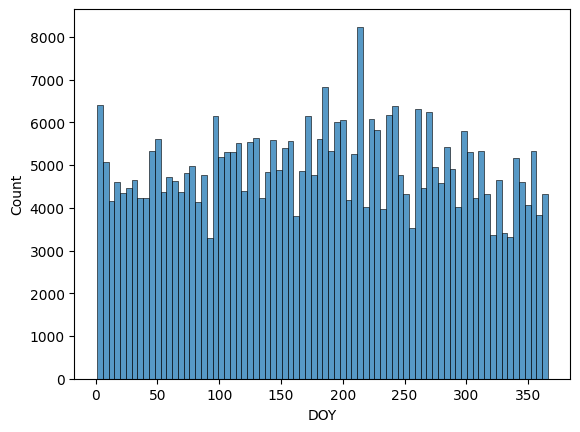

In [231]:
sns.histplot(
    data=train_df,
    x='DOY'
)

### 1.2. **`days_since_review`**: Преобразование в числовой формат ###

In [232]:
for str_ in train_df.days_since_review[:5]:
    print(str_)

531 day
203 day
289 day
681 day
516 day


In [233]:
train_df.days_since_review = \
    train_df.days_since_review.apply(lambda x: int(x.split()[0]))
test_df.days_since_review = \
    test_df.days_since_review.apply(lambda x: int(x.split()[0]))

### 1.2. **`hotel_name`**: ###

### 1.2. **`additional_number_of_scoring`**: ###

### 1.2. **`tags`**: Создание числового признака **`stayed_nights`** ###

In [234]:
for tag in train_df.tags[:5]:
    print(tag)

[' Leisure trip ', ' Couple ', ' Studio Suite ', ' Stayed 2 nights ', ' Submitted from a mobile device ']
[' Business trip ', ' Couple ', ' Standard Double Room ', ' Stayed 1 night ']
[' Leisure trip ', ' Solo traveler ', ' Modern Double Room Echo ', ' Stayed 3 nights ', ' Submitted from a mobile device ']
[' Leisure trip ', ' Solo traveler ', ' Standard Room with 1 Double Bed ', ' Stayed 1 night ']
[' Business trip ', ' Couple ', ' Standard Double or Twin Room ', ' Stayed 6 nights ']


In [235]:
def get_stayed_nights(tags_str: str) -> int:
    """ Разбивает строку признака 'tags' на отдельные тэги. Затем ищет
    тэг 'Stayed * nights' и возвращает число ночёвок. Если тэг не
    найден, возвращает 0.
    Arguments:
        tags_str [str] -- Содержимое ячейки признака 'tags'
    Returns:
        [int] -- Число проведённых в отеле ночей
    """
    tag_list = tags_str.lstrip('[').rstrip(']').split(', ')
    for tag in tag_list:
        tag = tag.lstrip("\' ").rstrip(" \'")
        words_list = tag.split()
        if words_list[0] == 'Stayed':
            return int(words_list[1])
    return 0


train_df['stayed_nights'] = train_df.tags.apply(get_stayed_nights)
test_df['stayed_nights'] = test_df.tags.apply(get_stayed_nights)

## 1. Отбор признаков ##

In [236]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

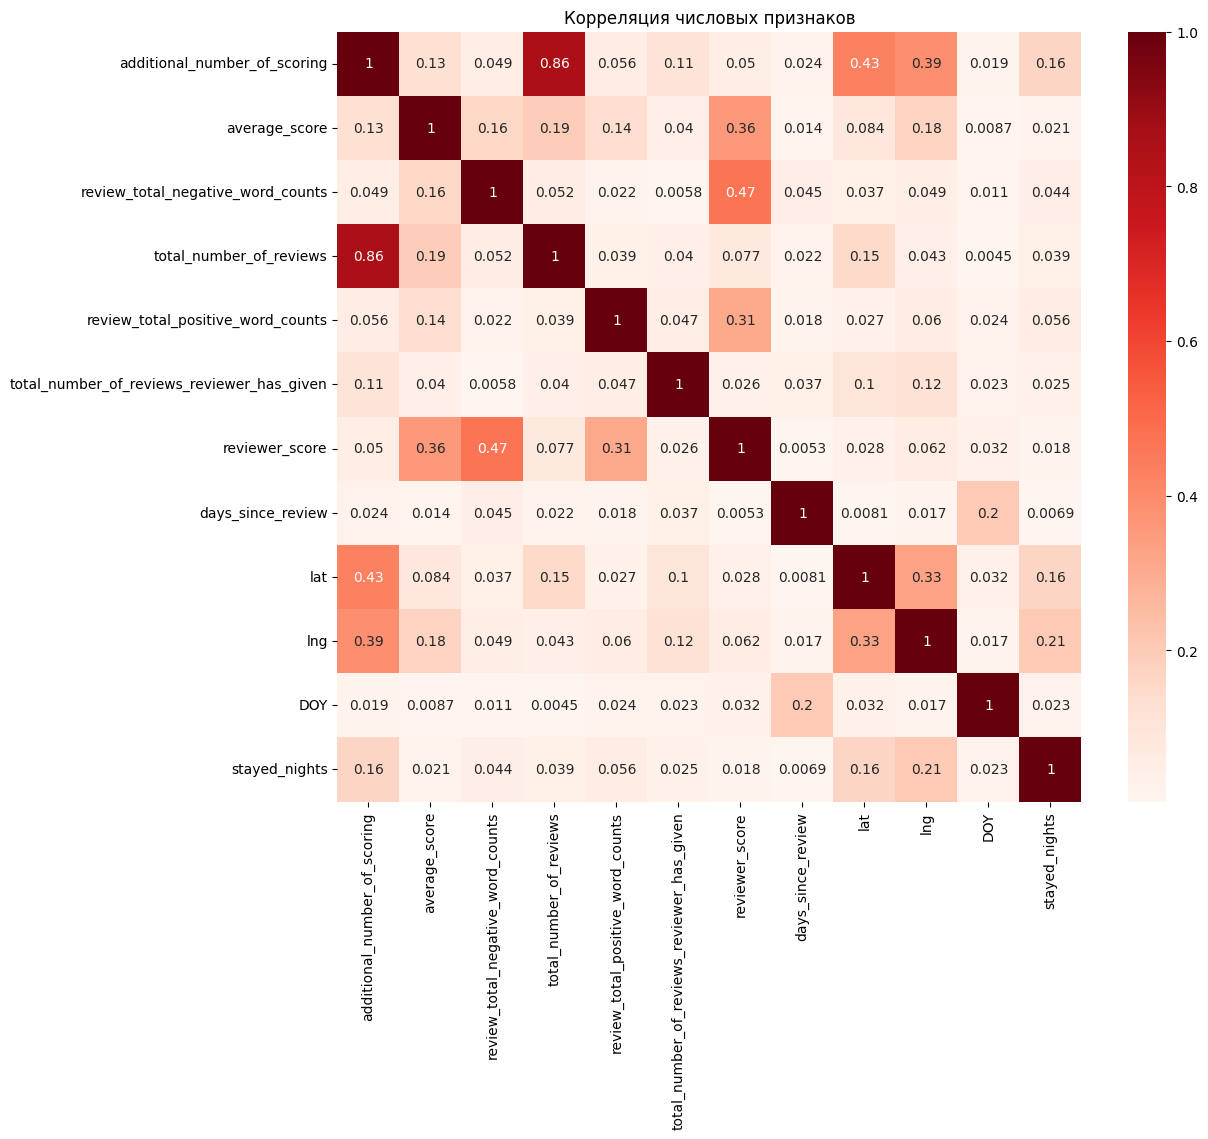

In [237]:
plt.figure(figsize=(12,10))
heatmap = sns.heatmap(data=train_df.corr(method='spearman').abs(), annot=True, cmap='Reds')
heatmap.set_title('Корреляция числовых признаков')
plt.show()

In [238]:
drop_features_list = [
    'hotel_address',
    # 'additional_number_of_scoring',
    'review_date',
    # 'average_score',
    'hotel_name',
    'reviewer_nationality',
    'negative_review',
    # 'review_total_negative_word_counts',
    # 'total_number_of_reviews',
    'positive_review',
    # 'review_total_positive_word_counts',
    # 'total_number_of_reviews_reviewer_has_given',
    # 'reviewer_score',
    'tags',
    # 'days_since_review',
    # 'city_Amsterdam',
    # 'city_Barcelona',
    # 'city_London',
    # 'city_Milan',
    # 'city_Paris',
    # 'city_Vienna',
    # 'lat',
    # 'lng'
]
train_df.drop(columns=drop_features_list, inplace=True)
test_df.drop(columns=drop_features_list, inplace=True)

## 1. Обучение модели ##

In [239]:
X = train_df.drop(columns=['reviewer_score'])
y = train_df.reviewer_score
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE
                                                   )

In [240]:
regressor = RandomForestRegressor(
                                    n_estimators=100,
                                    n_jobs=4,
                                    random_state=RANDOM_STATE
                                 )
regressor.fit(X_train, y_train)
y_predictor = regressor.predict(X_test)

## 1. Оценка качества модели ##

In [241]:
print(f'MAPE:', metrics.mean_absolute_percentage_error(y_test, y_predictor))

MAPE: 0.13721834285605328


## 1. Оценка значимости признаков ##

In [242]:
display(pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False))

review_total_negative_word_counts             0.281681
review_total_positive_word_counts             0.160415
average_score                                 0.090614
days_since_review                             0.088217
DOY                                           0.088069
lng                                           0.055135
lat                                           0.054829
total_number_of_reviews_reviewer_has_given    0.050842
total_number_of_reviews                       0.048853
additional_number_of_scoring                  0.046768
stayed_nights                                 0.034574
dtype: float64

## 1. Формирование предсказаний ##

In [18]:
predictions = regressor.predict(test_df)
submission_df.reviewer_score = predictions
submission_df.head()

,reviewer_score,id
0,8.415000,488440
1,7.308000,274649
2,8.223895,374688
3,8.725667,404352
4,9.883006,451596


In [19]:
submission_df.shape

(128935, 2)

In [20]:
submission_df.to_csv(OUTPUT_PATH + 'submission.csv', index=False)